In [1]:
!pip install -q -U 'tensorflow-text==2.8.*'

     |████████████████████████████████| 4.9 MB 12.6 MB/s 
     |████████████████████████████████| 498.0 MB 12 kB/s 
     |████████████████████████████████| 462 kB 62.8 MB/s 
     |████████████████████████████████| 1.4 MB 62.6 MB/s 
     |████████████████████████████████| 5.8 MB 63.7 MB/s 


In [2]:
!pip install -q tf-models-official

     |████████████████████████████████| 2.3 MB 14.8 MB/s 
     |████████████████████████████████| 1.3 MB 75.4 MB/s 
     |████████████████████████████████| 38.2 MB 154 kB/s 
     |████████████████████████████████| 662 kB 68.3 MB/s 
     |████████████████████████████████| 5.8 MB 70.0 MB/s 
     |████████████████████████████████| 238 kB 60.5 MB/s 
     |████████████████████████████████| 352 kB 29.0 MB/s 
     |████████████████████████████████| 1.1 MB 58.7 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
     |████████████████████████████████| 588.3 MB 22 kB/s 
     |████████████████████████████████| 118 kB 76.0 MB/s 
     |████████████████████████████████| 6.0 MB 71.7 MB/s 
     |████████████████████████████████| 439 kB 60.0 MB/s 
     |████████████████████████████████| 1.7 MB 65.0 MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import re
import time
import unicodedata
import datetime
import pathlib

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras import layers

import tensorflow_hub as hub
import tensorflow_models as tfm

import tensorflow_text as text
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [5]:
tf.get_logger().setLevel('ERROR')
tf.config.run_functions_eagerly(True)

### Variabili Globali

In [7]:
# PARAMETRI GLOBALI
root_folder = 'drive/MyDrive/BERT/'

# DATI
data_folder_name = 'data'
train_filename = 'ita.txt'

DATA_PATH = os.path.abspath(os.path.join(root_folder, data_folder_name))
train_filenamepath = os.path.abspath(os.path.join(DATA_PATH, train_filename))

# PATH LOG Tensorboard
PATH_LOG = 'logs/fit/transformer_no_bert_v2'
PATH_LOG = os.path.abspath(os.path.join(root_folder, PATH_LOG))
log_dir =  os.path.abspath(os.path.join(PATH_LOG, datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))) 

# PATH WEIGHTS Tensorboard
PATH_WEIGHTS = 'weights/transformer_nobert_v2'
PATH_WEIGHTS = os.path.abspath(os.path.join(root_folder, PATH_WEIGHTS))
checkpoint_path = os.path.abspath(os.path.join(PATH_WEIGHTS, 'cp.ckpt'))
log_weights = os.path.abspath(os.path.join(PATH_WEIGHTS, 'weights_30_epochs.h5'))

# MODELLO TOKENIZER
model_name = 'tokenizer_en_it_model'
tokenizer_folder_name = 'tokenizer'

TOKEN_PATH = os.path.abspath(os.path.join(root_folder, tokenizer_folder_name))
tokenizer_filenamepath = os.path.abspath(os.path.join(TOKEN_PATH, model_name))

In [8]:
# parametri per il modello
INPUT_COLUMN = 'input'
TARGET_COLUMN = 'target'
TARGET_FOR_INPUT = 'target_for_input'
NUM_SAMPLES = 27200 # portato da 10.000 a 100.000
TRAIN = 24000

MAX_VOCAB_SIZE = 20000 # portato da 20.0000 a 200.000
EMBEDDING_DIM = 64  # --> 256  Densa non lineare relu --> 64  Densa non lineare relu (oppure Conv1D kernel=1)
HIDDEN_DIM = 1024 # numero di celle nei layer ricorrenti nascosti

BATCH_SIZE = 32
BUFFER_SIZE = 2000
EPOCHS = 10
MAX_SEQ_LENGTH = 32 # --> portare a 10 con layer 'lambda'[:,:10]

NUM_LAYERS = 4 # Numero di layer di Encoder e Decoder del Transformer
NUM_HEADS = 8 # Numero di meccanismi di multi-head attention
FF_DIM = 16 # Numero di celle dei Layer Feed Forward
DROPUOT = 0.1

LEARNING_RATE=0.0003

# IMPOSTO IL DEBUG A TRUE 
debug = True
training = True

### Caricamento Dati

In [9]:
# Caricamento dataset: frasi in inglese, frasi in italiano
df = pd.read_csv(
    train_filenamepath,
    sep="\t",
    header=None,
    names=[INPUT_COLUMN, TARGET_COLUMN],
    usecols=[0,1],
    nrows=NUM_SAMPLES
)

print(df.iloc[10012:10016], '\n')

# Preprocessing dei dati di Input
input_data = df[INPUT_COLUMN].tolist()

# Preprocessing dei dati Target con aggiunta del token di fine frase
target_data = df[TARGET_COLUMN].tolist()

train_input_data = input_data[:TRAIN]
train_target_data = target_data[:TRAIN]

test_input_data = input_data[TRAIN:]
test_target_data = target_data[TRAIN:]

print('-----------TRAIN SET--------------')
print(train_input_data[-4:])
print(train_target_data[-4:])
print('-----------TEST SET---------------')
print(test_input_data[-4:])
print(test_target_data[-4:])


               input             target
10012  They're free.       Sono libere.
10013  They're free.  Loro sono libere.
10014  They're gone.       Sono andati.
10015  They're gone.  Loro sono andati. 

-----------TRAIN SET--------------
["You're a cutie.", "You're a cutie.", "You're a cutie.", "You're a cutie."]
['Sei una ragazza carina.', 'Sei una bella ragazza.', 'Tu sei una ragazza carina.', 'Tu sei una bella ragazza.']
-----------TEST SET---------------
['I sent Tom home.', 'I sent Tom home.', 'I sent her home.', 'I sent her home.']
['Mandai Tom a casa.', 'Io mandai Tom a casa.', "L'ho mandata a casa.", "Io l'ho mandata a casa."]


### Tokenizer

Carico il modello di tokenizer creato utilizzzando il set di dati a disposizione

In [10]:
tokenizers = tf.saved_model.load(tokenizer_filenamepath)

In [11]:
print(input_data[-2:])
print(tokenizers.en.tokenize(input_data[-2:]))
print(keras.preprocessing.sequence.pad_sequences(tokenizers.en.tokenize(input_data[-2:]).numpy(), maxlen=MAX_SEQ_LENGTH, padding='post'))
print(tokenizers.en.detokenize(tokenizers.en.tokenize(input_data[-2:])))
print('------------------------------------------------------------------')
print(target_data[-2:])
print(tokenizers.it.tokenize(target_data[-2:]))
print(keras.preprocessing.sequence.pad_sequences(tokenizers.it.tokenize(target_data[-2:]).numpy(), maxlen=MAX_SEQ_LENGTH, padding='post'))
print(tokenizers.it.detokenize(tokenizers.it.tokenize(target_data[-2:])))

['I sent her home.', 'I sent her home.']
<tf.RaggedTensor [[2, 34, 757, 139, 147, 11, 3],
 [2, 34, 757, 139, 147, 11, 3]]>
[[  2  34 757 139 147  11   3   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  2  34 757 139 147  11   3   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]]
tf.Tensor([b'i sent her home .' b'i sent her home .'], shape=(2,), dtype=string)
------------------------------------------------------------------
["L'ho mandata a casa.", "Io l'ho mandata a casa."]
<tf.RaggedTensor [[2, 37, 8, 66, 7931, 26, 105, 11, 3],
 [2, 60, 37, 8, 66, 7931, 26, 105, 11, 3]]>
[[   2   37    8   66 7931   26  105   11    3    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [   2   60   37    8   66 7931   26  105   11    3    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0

### Creazione dataset
Utilizzo della libreria tf.data per la gestione del dataset da utilizzare.
Verranno creati batch di esempi che verranno utilizzati durante l'addestramento.

In [12]:
def prepare_batch(en, it):
  zero = tf.zeros([BATCH_SIZE, MAX_SEQ_LENGTH], tf.int64)
  en = tokenizers.en.tokenize(en) # Output is ragged.
  en = tf.concat([en, zero], 1)
  en = en[:, :MAX_SEQ_LENGTH]     # Trim to MAX_TOKENS.
  en = en.to_tensor()             # Convert to 0-padded dense Tensor

  it = tokenizers.it.tokenize(it)
  it_inputs = it[:, :-1].to_tensor()  # Drop the [END] tokens
  it_labels = it[:, 1:].to_tensor()   # Drop the [START] tokens
  
  it_inputs = tf.concat([it_inputs, zero], 1)
  it_inputs = it_inputs[:, :(MAX_SEQ_LENGTH)]

  it_labels = tf.concat([it_labels, zero], 1)
  it_labels = it_labels[:, :(MAX_SEQ_LENGTH)]

  return (en, it_inputs), it_labels

In [13]:
def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

In [14]:
# Definizione del dataset
# [from_tensor_slices] permette di recuperare batch
# di esempi dai dataset di riferimento
train_dataset = tf.data.Dataset.from_tensor_slices((train_input_data, train_target_data))
test_dataset = tf.data.Dataset.from_tensor_slices((test_input_data, test_target_data))

# impostazione del recupero di esempi presi in maniera
# casuale in gruppi di [BATCH_SIZE] tra quelli disponibili
train_dataset = make_batches(train_dataset)
test_dataset = make_batches(test_dataset)

/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [15]:
# Recupero un batch di esempi per la verifica delle classi custom che andrò a creare
for (en_input, it_input), it_target in train_dataset.take(1):
  print(f'Shape en input           : {en_input.shape}')
  print(f'Example en input         : {en_input[0]}')  
  print('-------------------------------------------------------')
  print(f'Shape it input           : {it_input.shape}')
  print(f'Example it input         : {it_input[0]}')  
  print(f'Shape it input           : {it_target.shape}')
  print(f'Example it target        : {it_target[0]}')  

Shape en input           : (32, 32)
Example en input         : [   2   34   44 5809 4988   11    3    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
-------------------------------------------------------
Shape it input           : (32, 32)
Example it input         : [   2   66  132 6360   11    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
Shape it input           : (32, 32)
Example it target        : [  66  132 6360   11    3    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]


### Token and Position Embedding

Implementazione del blocco Embedding per l'utilizzo di vettori posizionali insieme ai vettori di token di parole tramite estensione della classe Layer di Keras

In [16]:
class TokenAndPositionEmbedding(layers.Layer):
  def __init__(self, maxlen, vocab_size, embed_dim):
    super(TokenAndPositionEmbedding, self).__init__()
    self.maxlen = maxlen
    self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
    self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

  def call(self, x, debug=False):
    x = keras.preprocessing.sequence.pad_sequences(x, maxlen=self.maxlen, padding='post')
    maxlen = tf.shape(x)[-1]

    if debug:
      print('********** DEBUG TOKEN AND POSITION EMBEDDING ***********')
      print(f'Sequence Max len                          : {maxlen}')
      print(f'Sequence Shape                            : {tf.shape(x)}')

    positions = tf.range(start=0, limit=maxlen, delta=1)
    positions = self.pos_emb(positions)
    x = self.token_emb(x)
    output = x + positions

    if debug:
      print(f'Shape TokenAndPositionEmbedding           : {output.shape}')
      print('*********************************************************')

    return output

In [17]:
token_position_en = TokenAndPositionEmbedding(MAX_SEQ_LENGTH, tokenizers.en.get_vocab_size(), EMBEDDING_DIM)
token_position_it = TokenAndPositionEmbedding(MAX_SEQ_LENGTH, tokenizers.it.get_vocab_size(), EMBEDDING_DIM)

inputs_encoder = token_position_en(en_input, debug)
inputs_decoder = token_position_it(it_input, debug)

********** DEBUG TOKEN AND POSITION EMBEDDING ***********
Sequence Max len                          : 32
Sequence Shape                            : [32 32]
Shape TokenAndPositionEmbedding           : (32, 32, 64)
*********************************************************
********** DEBUG TOKEN AND POSITION EMBEDDING ***********
Sequence Max len                          : 32
Sequence Shape                            : [32 32]
Shape TokenAndPositionEmbedding           : (32, 32, 64)
*********************************************************


### Encoder

Implmentazione di un blocco di EncoderTransformer tramite estensione della classe Layer di Keras

In [18]:
class Encoder(layers.Layer):
  def __init__(self, max_len, embed_dim, num_heads, ff_dim, rate=0.5, name='ENC'):
    super(Encoder, self).__init__()
    self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.ffn = keras.Sequential(
      [layers.Dense(ff_dim, activation='relu'), layers.Dense(embed_dim),]
    )
    self.layernorm1 = layers.LayerNormalization()
    self.layernorm2 = layers.LayerNormalization()
    self.dropout1 = layers.Dropout(rate)
    self.dropout2 = layers.Dropout(rate)
    self._name = name

  def call(self, inputs, training=False, debug=False):
    attn_output = self.att(query=inputs,
                           value=inputs, 
                           key=inputs)
    
    attn_output = self.dropout1(attn_output)
    out1 = self.layernorm1(inputs + attn_output)

    ffn_output = self.ffn(out1)
    ffn_output = self.dropout2(ffn_output, training=training)

    output = self.layernorm2(out1 + ffn_output)

    if debug:
      print('********************* DEBUG ENCODER *********************')
      print(f'Shape Input Layer Encoder       : {inputs.shape}')
      print(f'Shape Output Layer Encoder      : {output.shape}')
      print('*********************************************************')

    return output

In [19]:
encoder = Encoder(MAX_SEQ_LENGTH, 
                  EMBEDDING_DIM, 
                  NUM_HEADS, 
                  FF_DIM, 
                  DROPUOT)

outputs_encoder = encoder(inputs=inputs_encoder,
                          training=training, 
                          debug=debug)

********************* DEBUG ENCODER *********************
Shape Input Layer Encoder       : (32, 32, 64)
Shape Output Layer Encoder      : (32, 32, 64)
*********************************************************


### Decoder

Implementazione di un blocco di DecoderTransformer tramite estensione della classe Layer di Keras

In [20]:
class Decoder(layers.Layer):
  def __init__(self, max_len, embed_dim, num_heads, ff_dim, rate=0.5, name='DEC'):
    super(Decoder, self).__init__()
    self.att1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.att2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.ffn = keras.Sequential(
      [layers.Dense(ff_dim, activation='relu'), layers.Dense(embed_dim),]
    )
    self.layernorm1 = layers.LayerNormalization()
    self.layernorm2 = layers.LayerNormalization()
    self.layernorm3 = layers.LayerNormalization()
    self.dropout1 = layers.Dropout(rate)
    self.dropout2 = layers.Dropout(rate)
    self.dropout3 = layers.Dropout(rate)
    self._name = name

  def call(self, inputs, encoder_output, training=False, debug=False):
    attn_output1 = self.att1(query=inputs,
                             value=inputs, 
                             key=inputs, 
                             use_causal_mask=True)
    
    attn_output1 = self.dropout1(attn_output1)
    out1 = self.layernorm1(inputs + attn_output1)

    attn_output2 = self.att2(key=encoder_output, 
                             value=encoder_output, 
                             query=out1)
    
    attn_output2 = self.dropout2(attn_output2, training=training)
    out2 = self.layernorm2(out1 + attn_output2)

    ffn_output = self.ffn(out2)
    ffn_output = self.dropout3(ffn_output, training=training)

    output = self.layernorm3(out2 + ffn_output)

    if debug:
      print('******************* DEBUG DECODER ***********************')
      print(f'Input Shape                       : {inputs.shape}')
      print(f'Shape Outputs Decoder             : {output.shape}')
      print('*********************************************************')

    return output

In [21]:
decoder = Decoder(MAX_SEQ_LENGTH, 
                  EMBEDDING_DIM, 
                  NUM_HEADS, 
                  FF_DIM, 
                  DROPUOT)

outputs_decoder = decoder(inputs=inputs_decoder, 
                          encoder_output=outputs_encoder,  
                          training=training,
                          debug=debug)

******************* DEBUG DECODER ***********************
Input Shape                       : (32, 32, 64)
Shape Outputs Decoder             : (32, 32, 64)
*********************************************************


### Transformer

Implementazione del blocco Transformer tramite estensione della classe Layer di Keras

In [22]:
class TransformerBlock(keras.Model):
  def __init__(self, 
               num_layers, 
               embed_dim, 
               num_heads, 
               ff_dim, 
               max_len,
               input_vocab_size,
               target_vocab_size,
               rate=0.5):
    
    super(TransformerBlock, self).__init__()

    self.num_layers = num_layers

    self.token_pos_enc = TokenAndPositionEmbedding(max_len, input_vocab_size, embed_dim)
    self.token_pos_dec = TokenAndPositionEmbedding(max_len, target_vocab_size, embed_dim)

    self.encoder = [Encoder(max_len, embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)]
    self.decoder = [Decoder(max_len, embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)]

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    # self.soft = tf.keras.layers.Dense(target_vocab_size, activation='softmax')

  def call(self, inputs, training=False, debug=False):
    inputs_encoder, inputs_decoder  = inputs

    inputs_encoder = self.token_pos_enc(inputs_encoder, debug)
    inputs_decoder = self.token_pos_dec(inputs_decoder, debug)

    if debug:
      print(f'---------------- DEBUG TRANSFORMER BLOCK ----------------')
      print(f'inputs_encoder       : {inputs_encoder.shape}')
      print(f'inputs_decoder       : {inputs_decoder.shape}')      

    encoder_output = inputs_encoder
    transformer_output = inputs_decoder

    for i in range(self.num_layers):
      encoder_output = self.encoder[i](inputs=encoder_output, 
                                       training=training, 
                                       debug=debug) 
      
    for i in range(self.num_layers):
      transformer_output = self.decoder[i](inputs=transformer_output, 
                                           encoder_output=encoder_output, 
                                           training=training,
                                           debug=debug)

    logits = self.final_layer(transformer_output)
    # logits = self.soft(logits)

    if debug:
      print(f'Output Shape       : {logits.shape}')
      print(f'Output Transformer : {logits[0, :1, :12]}')    
      print(f'---------------------------------------------------------')

    return logits

In [23]:
transformer = TransformerBlock(NUM_LAYERS, 
                               EMBEDDING_DIM, 
                               NUM_HEADS, 
                               FF_DIM,
                               MAX_SEQ_LENGTH,
                               tokenizers.en.get_vocab_size(),
                               tokenizers.it.get_vocab_size(),
                               DROPUOT)

transformer_output = transformer((en_input, it_input), 
                                 training=training,
                                 debug=debug)

********** DEBUG TOKEN AND POSITION EMBEDDING ***********
Sequence Max len                          : 32
Sequence Shape                            : [32 32]
Shape TokenAndPositionEmbedding           : (32, 32, 64)
*********************************************************
********** DEBUG TOKEN AND POSITION EMBEDDING ***********
Sequence Max len                          : 32
Sequence Shape                            : [32 32]
Shape TokenAndPositionEmbedding           : (32, 32, 64)
*********************************************************
---------------- DEBUG TRANSFORMER BLOCK ----------------
inputs_encoder       : (32, 32, 64)
inputs_decoder       : (32, 32, 64)
********************* DEBUG ENCODER *********************
Shape Input Layer Encoder       : (32, 32, 64)
Shape Output Layer Encoder      : (32, 32, 64)
*********************************************************
********************* DEBUG ENCODER *********************
Shape Input Layer Encoder       : (32, 32, 64)
Shape Outpu

In [24]:
transformer.summary()

Model: "transformer_block"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token_and_position_embeddin  multiple                 395712    
 g_2 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 token_and_position_embeddin  multiple                 595840    
 g_3 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 ENC (Encoder)               multiple                  135056    
                                                                 
 ENC (Encoder)               multiple                  135056    
                                                                 
 ENC (Encoder)               multiple            

### Addestramento

In [25]:
transformer.compile(
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(epsilon=1e-9, learning_rate=LEARNING_RATE),
    metrics=['accuracy'])

In [26]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [27]:
start = datetime.datetime.now()
history = transformer.fit(train_dataset,
                          epochs=EPOCHS,
                          validation_data=test_dataset,
                          callbacks=[tensorboard_callback, 
                                     cp_callback])

end = datetime.datetime.now()
print(f'Tempo necessario per l\'addestramento: {end - start}')

Epoch 1/10
750/750 [==============================] - 616s 820ms/step - loss: 1.9820 - accuracy: 0.8646 - val_loss: 0.8355 - val_accuracy: 0.8773
Epoch 2/10
750/750 [==============================] - 620s 826ms/step - loss: 0.5978 - accuracy: 0.9137 - val_loss: 0.6644 - val_accuracy: 0.9037
Epoch 3/10
750/750 [==============================] - 612s 816ms/step - loss: 0.4830 - accuracy: 0.9244 - val_loss: 0.5902 - val_accuracy: 0.9105
Epoch 4/10
750/750 [==============================] - 628s 838ms/step - loss: 0.4110 - accuracy: 0.9310 - val_loss: 0.5450 - val_accuracy: 0.9144
Epoch 5/10
750/750 [==============================] - 605s 807ms/step - loss: 0.3550 - accuracy: 0.9366 - val_loss: 0.5162 - val_accuracy: 0.9183
Epoch 6/10
750/750 [==============================] - 616s 822ms/step - loss: 0.3068 - accuracy: 0.9421 - val_loss: 0.4887 - val_accuracy: 0.9224
Epoch 7/10
750/750 [==============================] - 595s 793ms/step - loss: 0.2640 - accuracy: 0.9474 - val_loss: 0.4656 -

### Valutazione dell'addestramento
Avendo in output il log ed i risultati dell'addestramento, possiamo visualizzare
queste informazioni relativamente alle metriche di interesse.

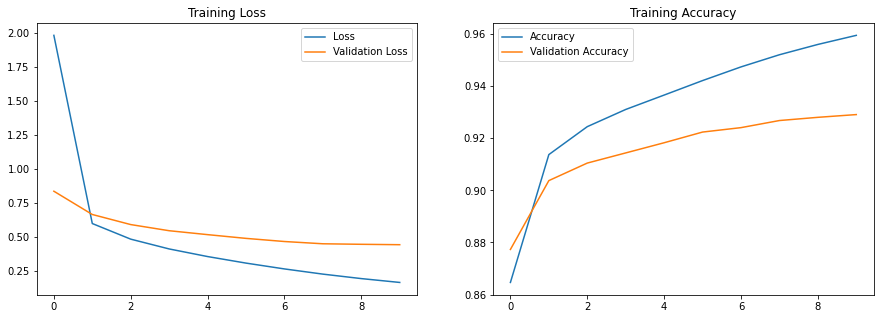

In [28]:
# visualizzazione andamento addestramento
# su un grafico composto da due sub-plot
# uno per il loss, l'altro per l'accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# Errore durante l'addestramento
ax1.plot(history.history['loss'], label='Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Training Loss')
ax1.legend()

# Accuratezza durante l'addestramento
ax2.plot(history.history['accuracy'], label='Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Training Accuracy')
ax2.legend()

plt.show()

### Test del modello
La seguente cella permette di caricare l'ultimo checkpoint dell'addestramento
precedentemente salvato.

In [29]:
# Carico i pesi modello
latest = tf.train.latest_checkpoint(PATH_WEIGHTS)
transformer.load_weights(latest)

In [30]:
class Translate:
  def __init__(self, transformer_block, tokenizers):
    self.transformer = transformer_block
    self.tokenizers = tokenizers

  def predict(self, input_text, max_length):
    if input_text is None:
      input_text = input_data[np.random.choice(len(input_data))]
      print(input_text)

    # print(input_text)
    inputs_encoder = self.tokenizers.en.tokenize(input_text).to_tensor()
    inputs_encoder = keras.preprocessing.sequence.pad_sequences(inputs_encoder, maxlen=max_length, padding='post')

    # print(inputs_encoder)
    
    start_end = self.tokenizers.it.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = (start_end[1][tf.newaxis]).numpy()[0]

    output_array = tf.TensorArray(dtype=tf.int64, size=max_length, dynamic_size=True)
    output_array = output_array.write(0, start)     

    out_words = []

    for i in tf.range(max_length):
      # decodifica e recupero probabilità di output
      output = tf.transpose(output_array.stack())
      # print('Output', output)
      transformer_output = transformer([inputs_encoder, output], 
                                        training=False,
                                        debug=False)

      predictions = transformer_output[:, -1:, :]

      # selezione della parola più probabile
      predict = tf.argmax(predictions, -1)
      pred_values = (K.argmax(transformer_output, axis=-1)).numpy()
      # preds = pred_values[0][predict.numpy()[0][0]]
      
      # print('predict',  predict)
      # print('predictions', transformer_output)
      # print('pred_values', pred_values[0][0])
      # print('predict[0]', pred_values[0][i])
      
  
      # print('Preds', preds)
      # print('Detokenize', (tokenizers.it.detokenize(pred_values)))
      # print('##########################')
    
      # inserimento della parola nella sequenza di output
      output_array = output_array.write(i+1, [pred_values[0][i]])
      # output_array = output_array.write(i+1, predict[0])

      # termine del ciclo quando si incontra il token <end-of-sentence>
      # oppure la lunghezza massima prevista della sequenza
      # print(end)
      if pred_values[0][i] == end:
        break

    output = tf.transpose(output_array.stack())
    text = tokenizers.it.detokenize(output)[0]  

    tokens = tokenizers.it.lookup(output)[0]

    return text, tokens

In [33]:
test_sequences = [test_input_data[41], test_input_data[102], test_input_data[612], test_input_data[3132], test_input_data[2222]]

translate = Translate(transformer_block=transformer,
                      tokenizers=tokenizers)

for test_sequence in test_sequences:
  text, token = translate.predict(tf.constant([test_sequence]), MAX_SEQ_LENGTH)

  print(f'{"Input:":15s}: {test_sequence}')
  print(f'{"Prediction":15s}: {text.numpy().decode("utf-8")}')  
  # print(f'tokens : {token}')
  # print(target_data[41])
  # break
  print('---------------------------------------------')

print(test_target_data[41])
print(test_target_data[102])
print(test_target_data[612])
print(test_target_data[3132])
print(test_target_data[2222])

Input:         : You're careful.
Prediction     : tu sei prudente .
---------------------------------------------
Input:         : You're jealous.
Prediction     : sei gelosa .
---------------------------------------------
Input:         : Are you sincere?
Prediction     : sei sincero ?
---------------------------------------------
Input:         : I saw Tom there.
Prediction     : io ho visto la .
---------------------------------------------
Input:         : I don't want it.
Prediction     : non la voglio .
---------------------------------------------
Tu sei prudente.
Voi siete gelose.
Siete sincere?
Io ho visto Tom lì.
Non la voglio.


### Tensorboard

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
log_dir

In [ ]:
%tensorboard --logdir drive/MyDrive/BERT/logs/fit/20221026-134720